In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import argparse
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
    
import torch
from torch import nn
import torch.nn.functional as F

from dataloader import mnist_usps, mnist_reverse, FaceLandmarksDataset, TabDataset
from module import Encoder, Decoder, Encoder_xya, Decoder_xyz
from eval import predict, cluster_accuracy, balance, calc_FID
from utils import set_seed, AverageMeter, target_distribution, aff, inv_lr_scheduler
import argparse

# from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from tqdm import tqdm


from aif360.metrics import ClassificationMetric
from aif360.datasets import AdultDataset, GermanDataset, BankDataset, CompasDataset, BinaryLabelDataset, CelebADataset, MEPSDataset19

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
args = argparse.ArgumentParser(description='Process some integers.')
args.bs = 256
args.test_interval = 200
args.lr = 1e-3

args.num_iter = 5000
args.lambda_ctr = 5e1
args.lambda_fair = 1.0
args.num_sens = 1
args.k = 10
data_name = 'adult'

In [5]:
dataset_orig = AdultDataset()
sens_idx = dataset_orig.feature_names.index('sex')


data_train, data_vt = dataset_orig.split([0.7], shuffle=True)
data_valid, data_test = data_vt.split([0.5], shuffle=True)


d_train = TabDataset(data_train, sens_idx)
v_train = TabDataset(data_valid, sens_idx)
t_train = TabDataset(data_test, sens_idx)

trainloader = torch.utils.data.DataLoader(
    d_train,
    batch_size=args.bs,
    shuffle=True,
    num_workers = 16
    )

validloader = torch.utils.data.DataLoader(
    v_train,
    batch_size=args.bs,
    shuffle=True,
    num_workers = 16
    )

testloader = torch.utils.data.DataLoader(
    t_train,
    batch_size=args.bs,
    shuffle=True,
    num_workers = 16
    )


In [14]:
class Encoder_tab(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder_tab, self).__init__()


        self.linear1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.linear3_1 = nn.Linear(64, latent_dim)
        self.linear3_2 = nn.Linear(64, latent_dim)

        self.relu = nn.ReLU()


    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        x = self.relu(self.bn1(self.linear1(x)))
        x = self.relu(self.bn2(self.linear2(x)))
        
        mu, logvar = self.linear3_1(x), self.linear3_2(x)
        
        z = self.reparameterize(mu, logvar)
        
        z = F.normalize(z, dim = 1)

        return z, mu, logvar

    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]
    
class Decoder_tab(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Decoder_tab, self).__init__()


        self.linear1 = nn.Linear(latent_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.linear2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.linear3 = nn.Linear(64, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.linear4 = nn.Linear(128, input_dim)

        self.relu = nn.ReLU()
        self.tanh = nn.Sigmoid()

    def forward(self, x):
        
        x = self.relu(self.bn1(self.linear1(x)))
        x = self.relu(self.bn2(self.linear2(x)))
        x = self.relu(self.bn3(self.linear3(x)))
        x = self.tanh(self.linear4(x))

        return x

    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

## Ordinary VAE

In [7]:
input_dim = dataset_orig.features.shape[1] - 1
latent_dim = 32

step : 0, recon loss : 744887.062, KLD loss : 50.927


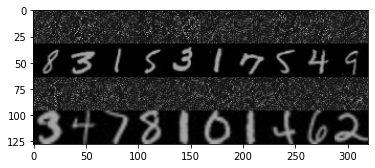

step : 100, recon loss : 105082.031, KLD loss : 253.738


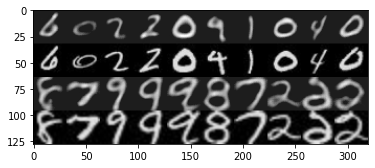

step : 200, recon loss : 81489.289, KLD loss : 292.826


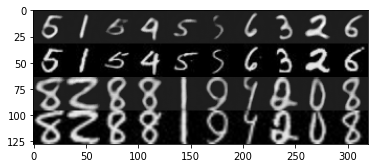

step : 300, recon loss : 73852.656, KLD loss : 316.569


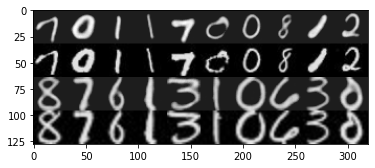

step : 400, recon loss : 71497.703, KLD loss : 336.069


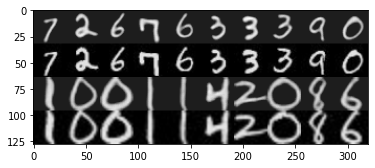

step : 500, recon loss : 68533.102, KLD loss : 347.561


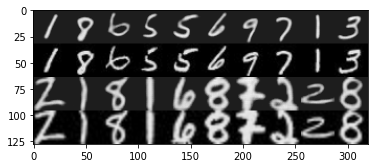

step : 600, recon loss : 66819.266, KLD loss : 358.784


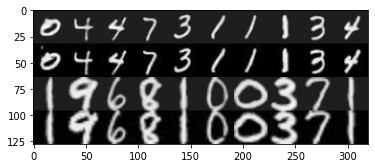

step : 700, recon loss : 66131.500, KLD loss : 368.039


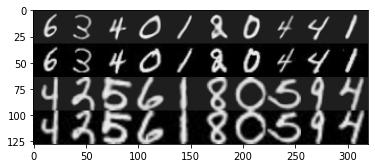

step : 800, recon loss : 65363.680, KLD loss : 375.598


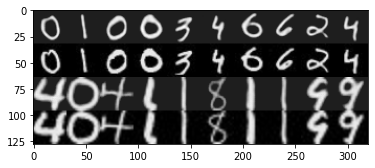

step : 900, recon loss : 64801.680, KLD loss : 383.100


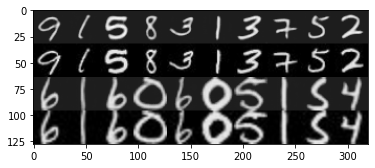

step : 1000, recon loss : 63976.309, KLD loss : 388.055


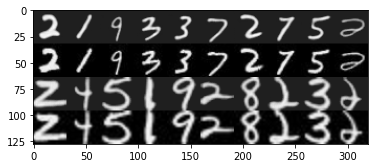

step : 1100, recon loss : 64190.770, KLD loss : 391.748


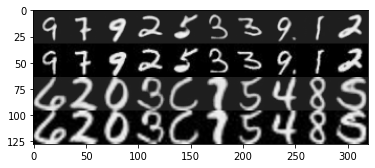

step : 1200, recon loss : 62763.062, KLD loss : 397.115


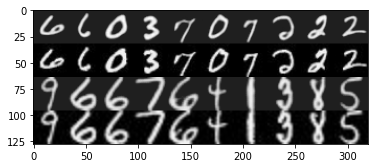

step : 1300, recon loss : 61786.016, KLD loss : 401.143


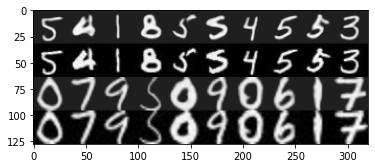

step : 1400, recon loss : 61464.133, KLD loss : 404.730


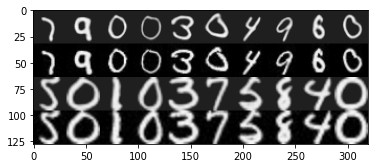

step : 1500, recon loss : 61369.312, KLD loss : 408.637


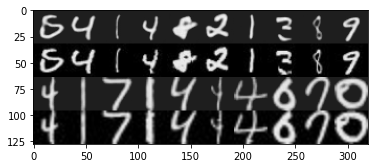

step : 1600, recon loss : 61478.273, KLD loss : 409.445


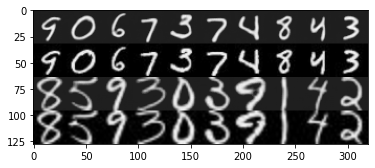

step : 1700, recon loss : 60529.484, KLD loss : 413.999


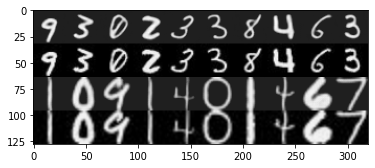

step : 1800, recon loss : 60685.352, KLD loss : 414.727


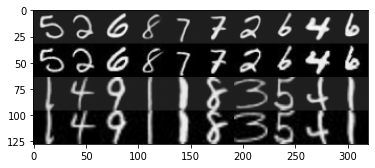

step : 1900, recon loss : 59561.660, KLD loss : 415.695


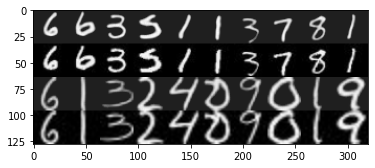

step : 2000, recon loss : 52688.203, KLD loss : 416.529
step : 2100, recon loss : 59774.477, KLD loss : 417.016


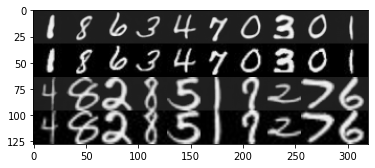

step : 2200, recon loss : 59546.188, KLD loss : 417.392


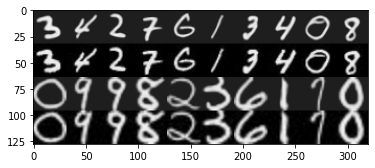

step : 2300, recon loss : 59298.586, KLD loss : 417.338


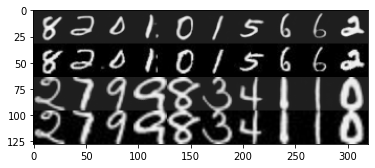

step : 2400, recon loss : 58495.188, KLD loss : 418.700


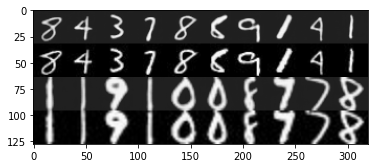

step : 2500, recon loss : 59412.469, KLD loss : 420.516


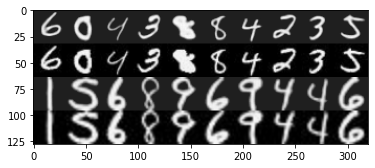

step : 2600, recon loss : 59046.594, KLD loss : 419.297


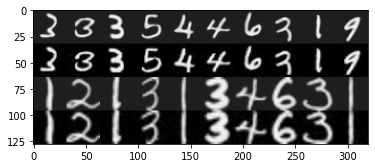

step : 2700, recon loss : 59501.543, KLD loss : 419.072


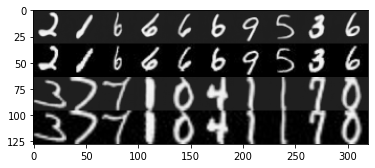

step : 2800, recon loss : 58270.293, KLD loss : 419.946


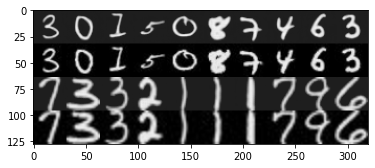

step : 2900, recon loss : 57980.461, KLD loss : 418.883


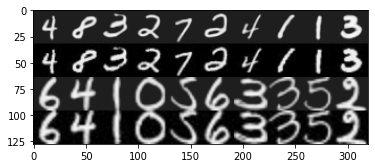

step : 3000, recon loss : 58975.020, KLD loss : 419.720


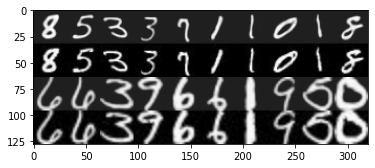

step : 3100, recon loss : 57044.227, KLD loss : 419.345


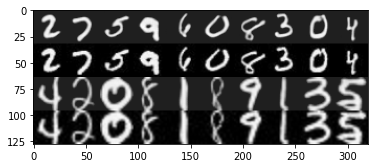

step : 3200, recon loss : 57638.172, KLD loss : 419.190


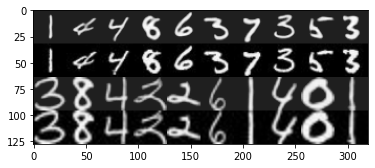

step : 3300, recon loss : 57043.488, KLD loss : 420.677


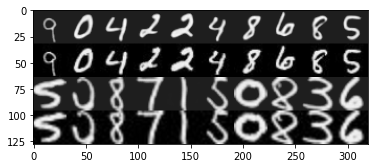

step : 3400, recon loss : 56905.969, KLD loss : 419.278


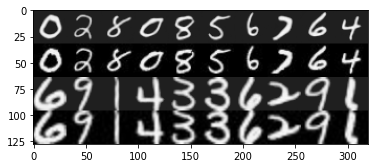

step : 3500, recon loss : 56788.641, KLD loss : 417.894


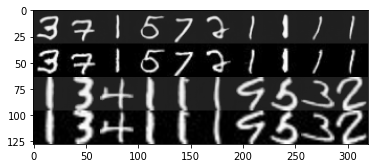

step : 3600, recon loss : 57237.289, KLD loss : 418.423


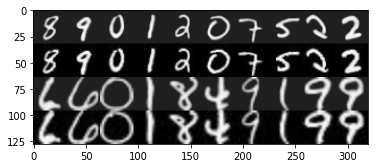

step : 3700, recon loss : 56724.961, KLD loss : 418.775


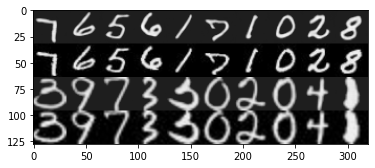

step : 3800, recon loss : 56897.125, KLD loss : 418.995


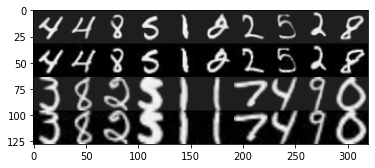

step : 3900, recon loss : 55985.543, KLD loss : 419.135


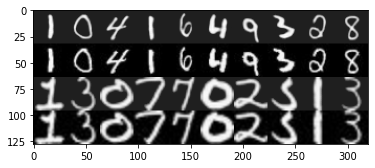

step : 4000, recon loss : 55664.875, KLD loss : 420.613


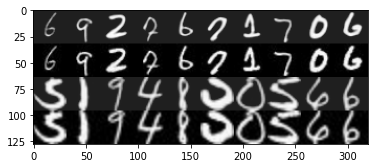

step : 4100, recon loss : 57175.289, KLD loss : 420.765


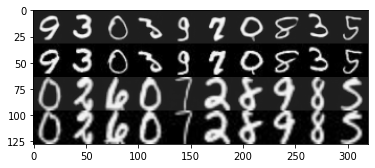

step : 4200, recon loss : 56482.094, KLD loss : 419.421


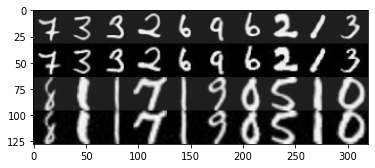

step : 4300, recon loss : 55923.789, KLD loss : 419.069


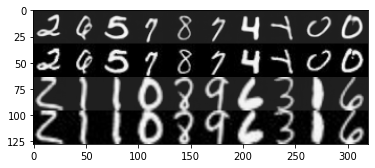

step : 4400, recon loss : 55417.375, KLD loss : 419.382


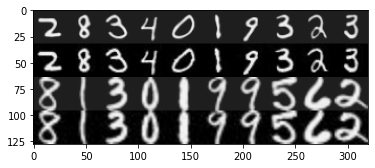

step : 4500, recon loss : 55946.977, KLD loss : 419.543


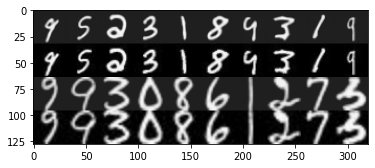

step : 4600, recon loss : 55880.383, KLD loss : 420.065


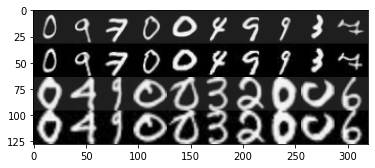

step : 4700, recon loss : 55955.141, KLD loss : 419.065


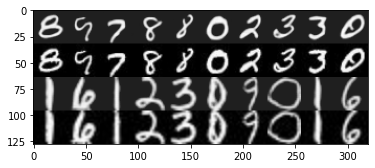

step : 4800, recon loss : 55271.820, KLD loss : 421.412


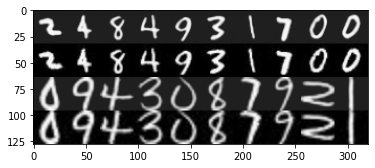

step : 4900, recon loss : 52767.609, KLD loss : 422.036


In [8]:
kld_weight = 1e-3
samples = 10
epochs = 1000
save = False

encoder = Encoder_tab(input_dim, latent_dim).cuda()
decoder = Decoder_tab(input_dim, latent_dim).cuda()

optimizer = torch.optim.Adam(encoder.get_parameters() + decoder.get_parameters(), lr = args.lr)

for epoch in tqdm(range(epochs + 1)):
    encoder.train()
    decoder.train()
    for x_batch, s_batch, y_batch in trainloader:
        x_batch = x_batch.cuda().float()
        
        z, mu, logvar = encoder(x_batch)

        recon = decoder(z)

        recons_loss = F.mse_loss(recon, x_batch, reduction = 'mean')
        kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1e2 == 0:
        print('epoch : {}, recon loss : {:.3f}, KLD loss : {:.3f}'.format(epoch, recons_loss, kld_loss))
        encoder.eval()
        decoder.eval()   
        
        with torch.no_grad():
            mnist_lst = list()
            usps_lst = list()
            label_mnist = list()
            label_usps = list()
            iters = iter(trainloader)
            
            for i in range(2):
                x_batch, s_batch, y_batch = iters.next()
                x_batch, s_batch, y_batch = x_batch.cuda().float(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

                z, mu, logvar = encoder(x_batch)

                mnist_lst.append(z[s_batch.view(-1) == 0])
                usps_lst.append(z[s_batch.view(-1) == 1])
                label_mnist.append(y_batch[s_batch.view(-1) == 0])
                label_usps.append(y_batch[s_batch.view(-1) == 1])

            mnist_lst = torch.cat(mnist_lst)
            usps_lst = torch.cat(usps_lst)
            label_mnist = torch.cat(label_mnist)
            label_usps  = torch.cat(label_usps)

            z = torch.cat([mnist_lst, usps_lst], 0)
            tsne =  TSNE(n_components=2, init='random').fit_transform(z.detach().cpu().numpy())

            plt.figure(figsize = (12,8))
            plt.scatter(tsne[:len(mnist_lst), 0], tsne[:len(mnist_lst), 1], c = label_mnist.cpu().numpy(), label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
            plt.scatter(tsne[len(mnist_lst):, 0], tsne[len(mnist_lst):, 1], c = label_usps.cpu().numpy(), marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
            # plt1.set_color('k')
            # plt2.set_color('k')
            plt1 = plt.scatter([], [], c = 'k', label = 'Group 0', cmap=plt.cm.get_cmap("jet"))
            plt2 = plt.scatter([], [], c = 'k', marker = 'x', label = 'Group 1', cmap=plt.cm.get_cmap("jet"))
            legend = plt.legend(handles = [plt1, plt2], fontsize = 12)
            plt.xticks([])
            plt.yticks([])
            plt.title('tsne z')
            plt.show()
            if save:
                plt.savefig('figure/{}/whole_space_base_{}.pdf'.format(data_name, epoch), ppi = 300, bbox_inches = 'tight')


## Sensitive information disentanglement

In [15]:
class Classifier(nn.Module):
    def __init__(self, input_dim = 32, hidden_dim = 128, output_dim = 1):
        super(Classifier, self).__init__()
        self.input_dim = input_dim 
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 1}]

In [ ]:
for lamda_a in [1e-1, 1e1]:
    kld_weight = 1e-4
    epochs = 200

    encoder_i = Encoder_tab(input_dim, latent_dim = 16).cuda()
    encoder_r = Encoder_tab(input_dim, latent_dim = 16).cuda()

    decoder = Decoder_tab(input_dim, latent_dim).cuda()
    # decoder_y = Classifier(input_dim = latent_dim * 2).cuda()

    cls_y = Classifier(input_dim = 16).cuda()
    cls_a = Classifier(input_dim = 16).cuda()

    vae_param_lst = encoder_i.get_parameters() + encoder_r.get_parameters() + decoder.get_parameters()
    cls_param_lst = cls_y.get_parameters() + cls_a.get_parameters()

    optimizer_vae = torch.optim.Adam(vae_param_lst, lr = 5e-3)
    optimizer_cls = torch.optim.Adam(cls_param_lst, lr = 1e-3)

    encoder_i.train()
    encoder_r.train()
    decoder.train()

    cls_y.train()
    cls_a.train()

    criterion_bce = torch.nn.BCEWithLogitsLoss()
    criterion_ce = torch.nn.CrossEntropyLoss()


    for epoch in tqdm(range(epochs+1)):
        for x_batch, s_batch, y_batch in trainloader:
            x_batch, s_batch, y_batch = \
                x_batch.cuda().float(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

            z_i, mu_i, logvar_i = encoder_i(x_batch)
            z_r, mu_r, logvar_r = encoder_r(x_batch)

            z = torch.cat([z_i, z_r], dim = 1)
            recon = decoder(z)

            recons_loss = F.mse_loss(recon, x_batch, reduction = 'mean')
            kld_loss = 0.
            kld_loss += torch.mean(-0.5 * torch.sum(1 + logvar_i - mu_i ** 2 - logvar_i.exp(), dim = 1), dim = 0)
            kld_loss += torch.mean(-0.5 * torch.sum(1 + logvar_r - mu_r ** 2 - logvar_r.exp(), dim = 1), dim = 0)

            pred_y = cls_y(z_i)
            pred_a = cls_a(z_r)

            loss_y = criterion_bce(pred_y, y_batch)
            loss_a = criterion_bce(pred_a, s_batch)

            loss = recons_loss + kld_weight * kld_loss + loss_y + lamda_a * loss_a

            optimizer_vae.zero_grad()
            optimizer_cls.zero_grad()
            loss.backward()
            optimizer_vae.step()
            optimizer_cls.step()

        if epoch % 2e1 == 0:
            pred_a = torch.sigmoid(pred_a)
            pred_a[pred_a>=0.5] = 1
            pred_a[pred_a<0.5] = 0
            pred_y = torch.sigmoid(pred_y)
            pred_y[pred_y>=0.5] = 1
            pred_y[pred_y<0.5] = 0

            acc_a = (pred_a == s_batch).float().mean()
            acc_y = (pred_y == y_batch).float().mean()

            print('epoch : {}, recon loss : {:.3f}, KLD loss : {:.3f}, Y loss : {:.3f}, A loss : {:.3f}'\
                          .format(epoch, recons_loss, kld_loss, loss_y, loss_a))
            print('epoch : {}, Acc Y : {:.3f}, Acc A : {:.3f}'.format(epoch, acc_y, acc_a))

    tsne(epoch, trainloader, encoder_i, encoder_r, save = False)
    
    torch.save({'state_dict':encoder_i.state_dict(), 'epoch':epoch}, './save/{}/encoder_i_la_{.1f}.pth'.format(data_name, lamda_a))
    torch.save({'state_dict':encoder_r.state_dict(), 'epoch':epoch}, './save/{}/encoder_r_la_{.1f}.pth'.format(data_name, lamda_a))
    torch.save({'state_dict':decoder.state_dict(), 'epoch':epoch}, './save/{}/decoder_la_{.1f}.pth'.format(data_name, lamda_a))
    torch.save({'state_dict':cls_y.state_dict(), 'epoch':epoch}, './save/{}/cls_y_la_{.1f}.pth'.format(data_name, lamda_a))
    torch.save({'state_dict':cls_a.state_dict(), 'epoch':epoch}, './save/{}/cls_a_la_{.1f}.pth'.format(data_name, lamda_a))

    
    

  0%|          | 1/201 [00:02<07:52,  2.36s/it]

epoch : 0, recon loss : 0.016, KLD loss : 47.236, Y loss : 0.340, A loss : 0.332
epoch : 0, Acc Y : 0.862, Acc A : 0.802


 10%|█         | 21/201 [00:48<06:59,  2.33s/it]

epoch : 20, recon loss : 0.003, KLD loss : 55.014, Y loss : 0.316, A loss : 0.223
epoch : 20, Acc Y : 0.868, Acc A : 0.892


 20%|██        | 41/201 [01:34<06:08,  2.30s/it]

epoch : 40, recon loss : 0.002, KLD loss : 52.658, Y loss : 0.248, A loss : 0.231
epoch : 40, Acc Y : 0.880, Acc A : 0.910


 29%|██▉       | 59/201 [02:15<05:22,  2.27s/it]

In [13]:
torch.save(encoder_i.state_dict(), './save/mnist-usps/encoder_i.pth')
torch.save(encoder_r.state_dict(), './save/mnist-usps/encoder_r.pth')
torch.save(decoder.state_dict(), './save/mnist-usps/decoder.pth')
torch.save(cls_y.state_dict(), './save/mnist-usps/cls_y.pth')
torch.save(cls_a.state_dict(), './save/mnist-usps/cls_a.pth')

## t-SNE Visualization

In [8]:
mnist_lst = list()
usps_lst = list()
label_mnist = list()
label_usps = list()
mnist_z_r_lst = list()
usps_z_r_lst = list()
mnist_z_i_lst = list()
usps_z_i_lst = list()

image_0, digit_0 = iter_image_0.__next__()
image_1, digit_1 = iter_image_1.__next__()

image_0, image_1 = image_0.cuda(), image_1.cuda()
digit_0, digit_1 = digit_0.cuda(), digit_1.cuda()
image = torch.cat((image_0, image_1), dim=0)
A = torch.cat([torch.zeros((len(image_0), 1)), torch.ones((len(image_1), 1))]).cuda()
Y = torch.cat((digit_0, digit_1)).view(-1,1)

z_i, mu_i, logvar_i = encoder_i(image, Y)
z_r, mu_r, logvar_r = encoder_r(image, [A, Y])
z = torch.cat([z_i, z_r], dim = 1)

mnist_lst.append(z[:len(image_0)])
usps_lst.append(z[len(image_0):])
mnist_z_r_lst.append(z_r[:len(image_0)])
usps_z_r_lst.append(z_r[len(image_0):])
mnist_z_i_lst.append(z_i[:len(image_0)])
usps_z_i_lst.append(z_i[len(image_0):])

label_mnist.append(digit_0)
label_usps.append(digit_1)

In [9]:
mnist_lst = torch.cat(mnist_lst)
usps_lst = torch.cat(usps_lst)
label_mnist = torch.cat(label_mnist)
label_usps  = torch.cat(label_usps)
mnist_z_r_lst = torch.cat(mnist_z_r_lst)
usps_z_r_lst = torch.cat(usps_z_r_lst)
mnist_z_i_lst = torch.cat(mnist_z_i_lst)
usps_z_i_lst = torch.cat(usps_z_i_lst)


/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


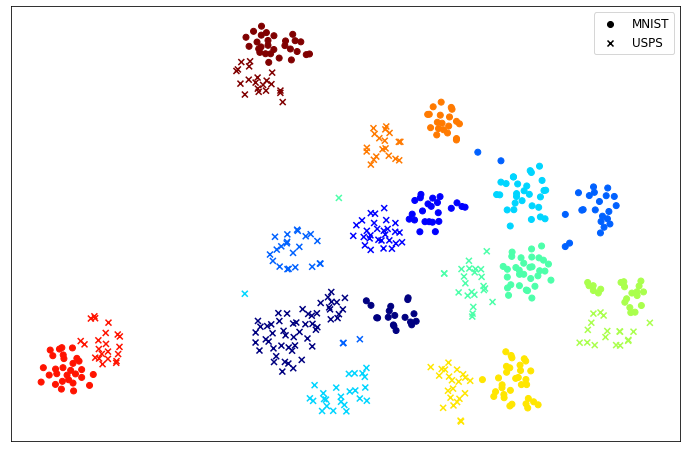

/tmp/ipykernel_2175170/597382640.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figure/mnist-usps/whole_space.pdf', ppi = 300, bbox_inches = 'tight')


<Figure size 432x288 with 0 Axes>

In [10]:
z = torch.cat([mnist_lst, usps_lst], 0)
tsne =  TSNE(n_components=2, init='random').fit_transform(z.detach().cpu().numpy())

plt.figure(figsize = (12,8))
plt.scatter(tsne[:len(mnist_lst), 0], tsne[:len(mnist_lst), 1], c = label_mnist.cpu().numpy(), label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt.scatter(tsne[len(mnist_lst):, 0], tsne[len(mnist_lst):, 1], c = label_usps.cpu().numpy(), marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
# plt1.set_color('k')
# plt2.set_color('k')
plt1 = plt.scatter([], [], c = 'k', label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt2 = plt.scatter([], [], c = 'k', marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
legend = plt.legend(handles = [plt1, plt2], fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('figure/mnist-usps/whole_space.pdf', ppi = 300, bbox_inches = 'tight')



/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


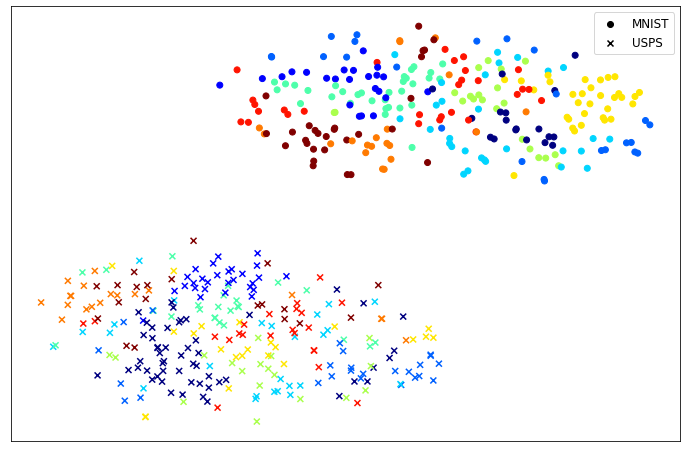

/tmp/ipykernel_2175170/995528691.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figure/mnist-usps/sens_relevant.pdf', ppi = 300, bbox_inches = 'tight')


<Figure size 432x288 with 0 Axes>

In [11]:
z = torch.cat([mnist_z_r_lst, usps_z_r_lst], 0)
tsne =  TSNE(n_components=2, init='random').fit_transform(z.detach().cpu().numpy())

plt.figure(figsize = (12,8))
plt.scatter(tsne[:len(mnist_lst), 0], tsne[:len(mnist_lst), 1], c = label_mnist.cpu().numpy(), label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt.scatter(tsne[len(mnist_lst):, 0], tsne[len(mnist_lst):, 1], c = label_usps.cpu().numpy(), marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
# plt1.set_color('k')
# plt2.set_color('k')
plt1 = plt.scatter([], [], c = 'k', label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt2 = plt.scatter([], [], c = 'k', marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
legend = plt.legend(handles = [plt1, plt2], fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('figure/mnist-usps/sens_relevant.pdf', ppi = 300, bbox_inches = 'tight')



/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


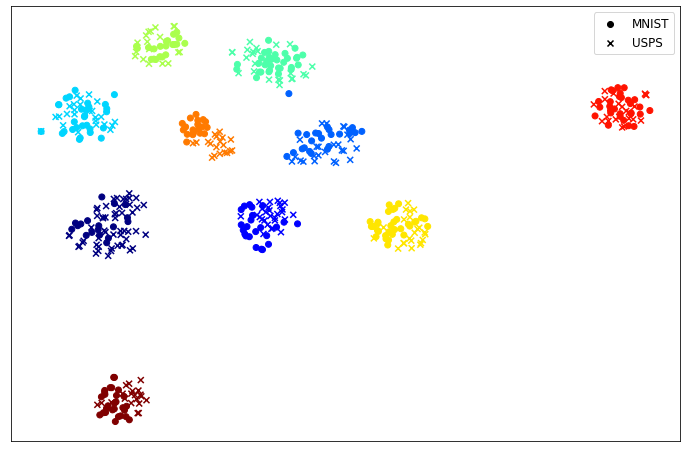

/tmp/ipykernel_2175170/1356618879.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('figure/mnist-usps/sens_irrelevant.pdf', ppi = 300, bbox_inches = 'tight')


<Figure size 432x288 with 0 Axes>

In [12]:
z = torch.cat([mnist_z_i_lst, usps_z_i_lst], 0)
tsne =  TSNE(n_components=2, init='random').fit_transform(z.detach().cpu().numpy())

plt.figure(figsize = (12,8))
plt.scatter(tsne[:len(mnist_lst), 0], tsne[:len(mnist_lst), 1], c = label_mnist.cpu().numpy(), label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt.scatter(tsne[len(mnist_lst):, 0], tsne[len(mnist_lst):, 1], c = label_usps.cpu().numpy(), marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
# plt1.set_color('k')
# plt2.set_color('k')
plt1 = plt.scatter([], [], c = 'k', label = 'MNIST', cmap=plt.cm.get_cmap("jet"))
plt2 = plt.scatter([], [], c = 'k', marker = 'x', label = 'USPS', cmap=plt.cm.get_cmap("jet"))
legend = plt.legend(handles = [plt1, plt2], fontsize = 12)
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('figure/mnist-usps/sens_irrelevant.pdf', ppi = 300, bbox_inches = 'tight')

